In [1]:
import RPi.GPIO as GPIO
import gpiozero
import time
import numpy as np
from matplotlib import pyplot as plt
from IPython import display



In [2]:
# Constants
# Encoder pins
# ML = motor left, MR = motor right
GPIO.cleanup()

GPIO.setmode(GPIO.BCM)

ML_ENC_A = 15 # yellow encoder c 23
ML_ENC_B = 14 # white encoder c 24

MR_ENC_A = 24 # yellow encoder c
MR_ENC_B = 23 # white encoder c

"""
- gear ratio = 75:1 = motor shaft rotates 75 times each revolution
- encoder = 48 CPR (count per revolution) = 48 counts each shaft rotation
- counts per round = count per rev * rev per round = 48*75 = 3600
"""
MAX_ENC_STEPS = 3600

# Motor Pins
ML_IN1 = 17 # IN1 10
ML_IN2 = 27 # IN2 22
ML_ENA = 11 # brown 9

MR_IN3 = 22 # IN3
MR_IN4 = 10 # IN4
MR_ENB = 9

# Physical dimensions
WHEEL_RADIUS = 0.056 # meters
WHEEL_SEP = 0.222 # meters


/tmp/ipykernel_4199/1530775278.py:4: RuntimeWarning: No channels have been set up yet - nothing to clean up!  Try cleaning up at the end of your program instead!
  GPIO.cleanup()


In [3]:

# wheel separation measurement (ASCII art)
"""
    <------- l ------->
    |                 |
 ___|___           ___|___
|       |         |       |
|   O   |         |   O   |
|_______|         |_______|
    ^                 ^
    |                 |
  Left wheel       Right wheel
  center            center
"""

class DiffDriveRobot:
    def __init__(
            self, 
            dt=0.1, 
            motor_calibration_factor=0,
            wheel_radius=WHEEL_RADIUS, 
            wheel_sep=WHEEL_SEP,
            max_enc_steps=MAX_ENC_STEPS,
            ml_pwm=ML_ENA,
            mr_pwm=MR_ENB,
            ml_in1=ML_IN1,
            ml_in2=ML_IN2,
            mr_in3=MR_IN3,
            mr_in4=MR_IN4,
            ml_encA=ML_ENC_A,
            ml_encB=ML_ENC_B,
            mr_encA=MR_ENC_A,
            mr_encB=MR_ENC_B
    ):
        self.x = 0.0  # x-position
        self.y = 0.0  # y-position 
        self.th = 0.0  # orientation
        
        self.wl = 0.0  # rotational velocity left wheel
        self.wr = 0.0  # rotational velocity right wheel
        
        self.dt = dt # time delta in seconds
        self.r = wheel_radius # wheel radius in meters
        self.l = wheel_sep # wheel separation in meters
        self.max_enc_steps = max_enc_steps # steps in the encoder per revolution
        self.motor_calibration_factor = motor_calibration_factor 
            # About the motor calibration factor:
        #  - If the factor is negative (right motor slower), we increase the right motor's duty cycle as a % of itself
        #  - If the factor is positive (left motor slower), we increase the left motor's duty cycle as a % of itself
        #  - This is to compensate in differences between left and right motor max speed
        # To calculate the calibration factor: NVM I THINK TRIAL AND ERROR IS BETTER: the curve is nonlinear
        # Go to the random_tidbits notebook, drive the motors at the same duty cycle, take note of their velocities
        # Do (bigger_one - smaller_one / smaller_one). If smaller_one is left motor, make it +ve. otherwise, -ve.
        
        # Pin numbers
        self.motor_L_in1 = ml_in1 # Input 1 (motor left)
        self.motor_L_in2 = ml_in2 # Input 2 (motor left)
        self.motor_R_in3 = mr_in3 # Input 3 (motor right)
        self.motor_R_in4 = mr_in4 # Input 4 (motor right)
        GPIO.setup(self.motor_L_in1, GPIO.OUT)
        GPIO.setup(self.motor_L_in2, GPIO.OUT)
        GPIO.setup(self.motor_R_in3, GPIO.OUT)
        GPIO.setup(self.motor_R_in4, GPIO.OUT)      
        
        # Initialize encoders
        self.ML_ENC = gpiozero.RotaryEncoder(a=ml_encA, b=ml_encB, max_steps=max_enc_steps, wrap=True)
        self.MR_ENC = gpiozero.RotaryEncoder(a=mr_encA, b=mr_encB, max_steps=max_enc_steps, wrap=True)
        self.ml_enc_steps = 0 # left motor encoder value (AKA shaft angle) in steps. 
        self.mr_enc_steps = 0 # right motor encoder value (AKA shaft angle) in steps. 

        # Initialize motor control pins
        GPIO.setup(ml_pwm, GPIO.OUT)
        GPIO.setup(mr_pwm, GPIO.OUT)
        self.motor_L_pwm = GPIO.PWM(ml_pwm, 1000)  # 1000 Hz frequency
        self.motor_R_pwm = GPIO.PWM(mr_pwm, 1000)
        self.motor_L_pwm.start(0)
        self.motor_R_pwm.start(0)
        

    def read_wheel_velocities(self, dt=None):
        if not dt:
            dt = self.dt
        ml_enc_now = self.ML_ENC.steps
        mr_enc_now = self.MR_ENC.steps

        # Calculate change in steps, accounting for wrap-around
        ml_enc_delta = (ml_enc_now - self.ml_enc_steps + self.max_enc_steps) % (2 * self.max_enc_steps) - self.max_enc_steps
        mr_enc_delta = (mr_enc_now - self.mr_enc_steps + self.max_enc_steps) % (2 * self.max_enc_steps) - self.max_enc_steps
        
        # Convert step change to radians
        ml_delta_rad = ml_enc_delta / self.max_enc_steps * 2 * np.pi
        mr_delta_rad = mr_enc_delta / self.max_enc_steps * 2 * np.pi

        # Calculate velocities
        self.wl = ml_delta_rad / dt
        self.wr = mr_delta_rad / dt

        # Update previous steps
        self.ml_enc_steps = ml_enc_now
        self.mr_enc_steps = mr_enc_now

        return self.wl, self.wr
  

    def set_motor_speed(self, left_duty_cycle, right_duty_cycle, apply_calibration_factor=True):      
        # Set direction
        GPIO.output(self.motor_L_in1, GPIO.HIGH if left_duty_cycle >= 0 else GPIO.LOW)
        GPIO.output(self.motor_L_in2, GPIO.LOW if left_duty_cycle >= 0 else GPIO.HIGH)
        GPIO.output(self.motor_R_in3, GPIO.HIGH if right_duty_cycle >= 0 else GPIO.LOW)
        GPIO.output(self.motor_R_in4, GPIO.LOW if right_duty_cycle >= 0 else GPIO.HIGH)
        if apply_calibration_factor:
            if self.motor_calibration_factor < 0:  # Left motor is faster
                right_duty_cycle *= (1 + abs(self.motor_calibration_factor))
            elif self.motor_calibration_factor > 0:  # Right motor is faster
                left_duty_cycle *= (1 + self.motor_calibration_factor)
            
            # Find the maximum absolute duty cycle
            max_duty = max(abs(left_duty_cycle), abs(right_duty_cycle))

            # If max_duty is greater than 1, scale both duty cycles
            if max_duty > 1:
                left_duty_cycle /= max_duty
                right_duty_cycle /= max_duty
            
        # Set speed
        self.motor_L_pwm.ChangeDutyCycle(abs(left_duty_cycle) * 100)
        self.motor_R_pwm.ChangeDutyCycle(abs(right_duty_cycle) * 100)

    def base_velocity(self, wl, wr):
        v = (wl * self.r + wr * self.r) / 2.0 # linear velocity, m/s, +ve is forward
        w = -(wl * self.r - wr * self.r) / self.l # angular velocity, rad/s, +ve is CCW. Note that the negative sign
        # is due to the way the motors are oriented, and so we need it to 'correct' our w calculation
        # so that +ve w is CCW, adhering to convention.
        return v, w

    def pose_update(self, duty_cycle_ml, duty_cycle_mr, dt=None, apply_calibration_factor=True):
        if not dt:
            dt = self.dt
            
        self.set_motor_speed(duty_cycle_ml, duty_cycle_mr, apply_calibration_factor)
        wl, wr = self.read_wheel_velocities() # get wheel velocities 
        v, w = self.base_velocity(wl, wr)
        
        self.x = self.x + dt * v * np.cos(self.th)
        self.y = self.y + dt * v * np.sin(self.th)
        self.th = self.th + w * dt
        
        return self.x, self.y, self.th

    
class RobotController:
    
    def __init__(self, Kp=0.2, Ki=0.0, Kd=0, wheel_radius=WHEEL_RADIUS, wheel_sep=WHEEL_SEP):
        
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.r = wheel_radius
        self.l = wheel_sep
        self.e_sum_l = 0
        self.e_sum_r = 0
        self.e_l_prev = 0
        self.e_r_prev = 0
    
        
    def scale_velocities(self, duty_cycle_l, duty_cycle_r):
            
        # Find the maximum absolute duty cycle
        max_duty = max(abs(duty_cycle_l), abs(duty_cycle_r))

        # If max_duty is greater than 1, scale both duty cycles
        if max_duty > 1:
            duty_cycle_l /= max_duty
            duty_cycle_r /= max_duty

        return duty_cycle_l, duty_cycle_r
    
#     def p_control(self, w_desired, w_measured, e_sum, dt):
#         error = w_desired - w_measured
#         p_term = self.Kp * error
#         i_term = self.Ki * e_sum * dt  # Note: Integrate error over time
# #         duty_cycle = min(max(-1, p_term + i_term), 1)
#         duty_cycle = p_term + i_term
#         e_sum = e_sum + error * dt  # Accumulate error over actual time
        
#         return duty_cycle, e_sum
    
    def pid_control(self, w_desired, w_measured, e_sum, last_error, dt):
        error = w_desired - w_measured
        p_term = self.Kp * error
        i_term = self.Ki * e_sum * dt
        d_term = self.Kd * (error - last_error) / dt

        duty_cycle = p_term + i_term + d_term
        duty_cycle = min(max(-1, duty_cycle), 1)

#         # Anti-windup
#         if abs(duty_cycle) < 1:
#             e_sum = e_sum + error * dt
        e_sum = e_sum + error * dt  # Accumulate error over actual time

        return duty_cycle, e_sum, error

    def drive(self, v_desired, w_desired, wl, wr, dt):
        
        wl_desired = (v_desired + self.l*w_desired/2)/self.r
        wr_desired = (v_desired - self.l*w_desired/2)/self.r
        
#         duty_cycle_l, self.e_sum_l = self.p_control(wl_desired, wl, self.e_sum_l, dt)
#         duty_cycle_r, self.e_sum_r = self.p_control(wr_desired, wr, self.e_sum_r, dt)
        
        duty_cycle_l, self.e_sum_l, self.e_l_prev = self.pid_control(wl_desired, wl, self.e_sum_l, self.e_l_prev, dt)
        duty_cycle_r, self.e_sum_r, self.e_r_prev = self.pid_control(wr_desired, wr, self.e_sum_r, self.e_r_prev, dt)
        
        
        # Normalise duty cycles to 1
#         duty_cycle_l, duty_cycle_r = self.scale_velocities(duty_cycle_l, duty_cycle_r)

        return duty_cycle_l, duty_cycle_r
    
    
    

In [4]:
GPIO.setwarnings(False)
robot = DiffDriveRobot(0.05)

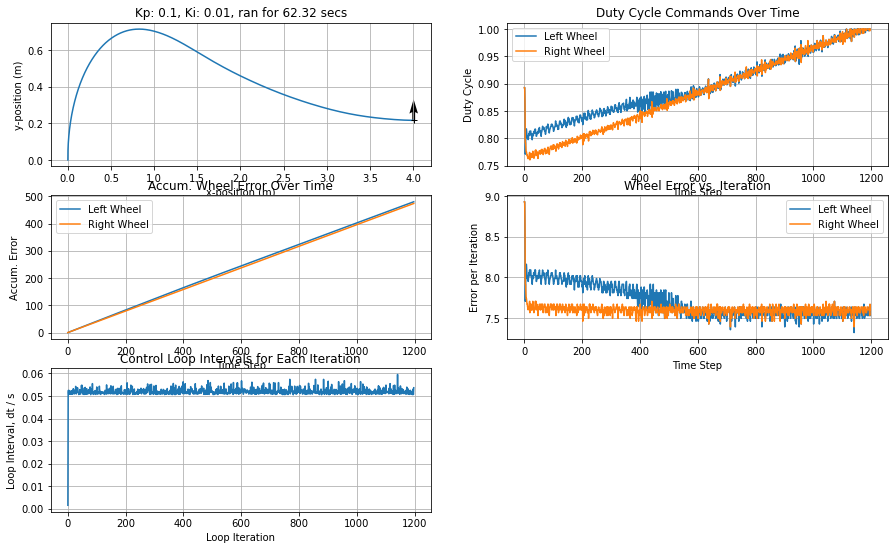

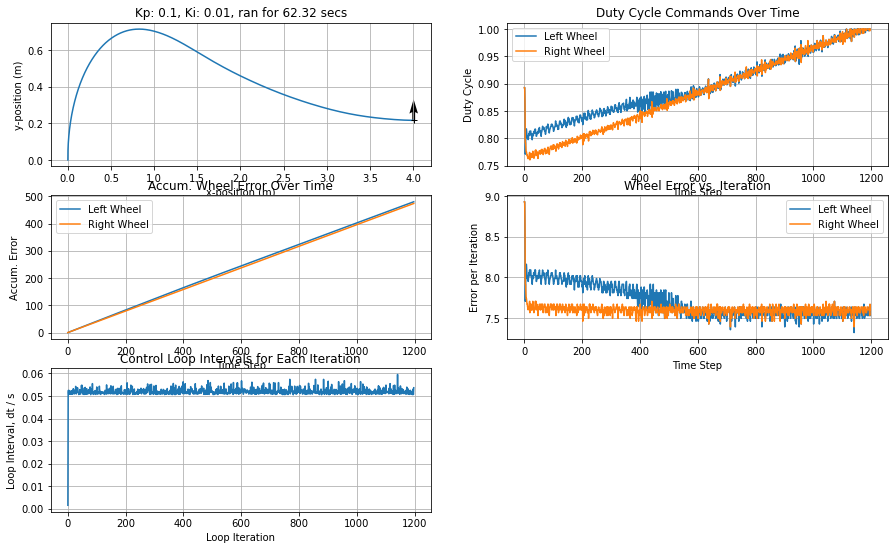

In [5]:
# Main control loop
robot.motor_calibration_factor=0.15


# Example: Move forward at 0.5 m/s with no rotation
v_desired = 0.5
w_desired = 0.0

# Parameters
Kp = 0.1
Ki = 0.01
Kd = 0.0

# Initialising
controller = RobotController(Kp, Ki, Kd)

poses = []
velocities = []
duty_cycle_commands = []
error_sums = []
errors = []
actual_dts = []


start_time, last_time = time.time(), time.time()

try:
    while True: 
        current_time = time.time()
        actual_dt = current_time - last_time

        duty_cycle_l, duty_cycle_r = controller.drive(v_desired, w_desired, robot.wl, robot.wr, actual_dt)

        print(f"v_des: {v_desired:.2f}, w_des: {w_desired:.2f}, v_actual: {robot.wl:.2f}, w_actual: {robot.wr:.2f}")
        print(f"duty cycle l: {duty_cycle_l:.2f}, r: {duty_cycle_r:.2f}")
        
        x, y, th = robot.pose_update(duty_cycle_l, duty_cycle_r, actual_dt)
        
        # Log data
        poses.append([x,y,th])
        duty_cycle_commands.append([duty_cycle_l,duty_cycle_r])
        velocities.append([robot.wl,robot.wr])
        error_sums.append([controller.e_sum_l, controller.e_sum_r])
        errors.append([controller.e_l_prev, controller.e_r_prev])
        actual_dts.append(actual_dt)
        
        print(f"Position: ({x:.2f}, {y:.2f}), Orientation: {th:.2f}\n")
        
        last_time = current_time
        time.sleep(robot.dt)

except KeyboardInterrupt:
    print("Stopping robot")
    robot.set_motor_speed(0, 0)
    end_time = time.time()
    duration = end_time - start_time


    # Plot robot data
    display.clear_output(wait=True)
    plt.figure(figsize=(15,9))
    
    plt.subplot(3, 2, 1)
    plt.plot(np.array(poses)[:,0],np.array(poses)[:,1])
    plt.plot(x,y,'k',marker='+')
    plt.quiver(x,y,0.1*np.cos(th),0.1*np.sin(th))
    plt.xlabel('x-position (m)')
    plt.ylabel('y-position (m)')
    plt.title(f"Kp: {Kp}, Ki: {Ki}, ran for {duration:.2f} secs")
#     plt.axis('equal')
    plt.grid()

    plt.subplot(3, 2, 2)
    duty_cycle_commands = np.array(duty_cycle_commands)
    plt.plot(duty_cycle_commands[:, 0], label='Left Wheel')
    plt.plot(duty_cycle_commands[:, 1], label='Right Wheel')
    plt.xlabel('Time Step')
    plt.ylabel('Duty Cycle')
    plt.title('Duty Cycle Commands Over Time')
    plt.legend() 
    plt.grid()
    
    plt.subplot(3, 2, 3)
    error_sums = np.array(error_sums)
    plt.plot(error_sums[:, 0], label='Left Wheel')
    plt.plot(error_sums[:, 1], label='Right Wheel')
    plt.xlabel('Time Step')
    plt.ylabel('Accum. Error')
    plt.title('Accum. Wheel Error Over Time')
    plt.legend() 
    plt.grid()
        
    plt.subplot(3, 2, 4)
    errors = np.array(errors)
    plt.plot(errors[:, 0], label='Left Wheel')
    plt.plot(errors[:, 1], label='Right Wheel')
    plt.xlabel('Time Step')
    plt.ylabel('Error per Iteration')
    plt.title('Wheel Error vs. Iteration')
    plt.legend() 
    plt.grid()
    
    plt.subplot(3, 2, 5)
    plt.plot(range(len(actual_dts)), actual_dts)
    plt.xlabel('Loop Iteration')
    plt.ylabel('Loop Interval, dt / s')
    plt.title('Control Loop Intervals for Each Iteration')
    plt.grid()
    
    display.display(plt.gcf())

#     GPIO.cleanup()

    


In [6]:
    robot.set_motor_speed(0, 0)

In [7]:
###################

# Choose option 1 to have the motors turn and print out encoder steps.
# What you're looking for is:
# - The correct motor is spinning, i.e. only the left motor spins if you do robot.set_motor_speed(0, 1)
#     - If the wrong motor spins, check pin assignments.
# - The motor is spinning in the correct direction for the given velocity. e.g. Forwards for 1, backwards for -1.
#.    - To reverse direction, swap the IN1 / IN2 assignments or IN3 / IN4 assignments. 
# - The encoder values are correct for the given velocity. e.g. they should be counting upwards if velocity is positive.
#     - If encoder values are always 0, check that the motor cables are plugged in correctly.
#.    - If they're counting the wrong direction, you need to swap the ENC_A and ENC_B pin assignments for the appropriate encoder


# Choose option 2 to test the pose_update method

OPTION = 0






################

if OPTION==1:
    # First argument is the left motor, second argument is the right motor.
    robot.set_motor_speed(1, 1)


poses = []
velocities = []
duty_cycle_commands = []

if OPTION != 0:
    try:
        while True:
            if OPTION == 1:
                print(f"l: {robot.ML_ENC.steps}, r: {robot.MR_ENC.steps}")
                wl, wr = robot.read_wheel_velocities()
                print(f"wl: {wl}, wr: {wr}")

            elif OPTION == 2:
                x, y, th = robot.pose_update(1, 1)
                poses.append([x,y,th])
                velocities.append([robot.wl,robot.wr])
                print(f"x:{x:.2f}, y:{y:.2f}, th: {th:.2f}\n")

            time.sleep(robot.dt)


    except KeyboardInterrupt:
        print("Stopping robot")
        robot.set_motor_speed(0, 0)

In [8]:
# plt.figure(figsize=(15,9))

graph = False

if graph:

    # Plot robot data
    plt.clf()
    plt.figure()

    plt.plot(np.array(poses)[:,0],np.array(poses)[:,1])
    # plt.plot(x,y,'k',marker='+')
    plt.quiver(x,y,0.1*np.cos(th),0.1*np.sin(th))
    # plt.plot(goal_x,goal_y,'x',markersize=5)
    # plt.quiver(goal_x,goal_y,0.1*np.cos(goal_th),0.1*np.sin(goal_th))
    # plt.xlim(-1,1)
    # plt.ylim(-1,1)
    plt.xlabel('x-position (m)')
    plt.ylabel('y-position (m)')
    plt.grid()


    plt.figure()
    plt.subplot(1,2,1)
    plt.plot(range(len(np.array(velocities)[:,0])),np.array(velocities)[:,0])
    plt.subplot(1,2,2)
    plt.plot(range(len(np.array(velocities)[:,1])),np.array(velocities)[:,1])


    # plt.subplot(2,2,2)
    # plt.plot(np.arange(i+1)*robot.dt,np.array(duty_cycle_commands))
    # plt.xlabel('Time (s)')
    # plt.ylabel('Duty cycle')
    # plt.grid()

    # plt.subplot(2,2,4)
    # for i in range(300):
    #     plt.plot(np.arange(i+1)*robot.dt,np.array(velocities))

    #     plt.xlabel('Time (s)')
    # plt.ylabel('Wheel $\omega$')
    # plt.legend(['Left wheel', 'Right wheel'])
    # plt.grid()


    # display.clear_output(wait=True)
    display.display(plt.gcf())



In [9]:
# # Real time, updating graphs. 
# # Do not use for now, interferes with velocity control.

# plt.figure(figsize=(15,9))


# # Example: Move forward at 0.5 m/s with no rotation
# Kp = 0.6
# Ki = 0.0

# v_desired = 0.5
# w_desired = 0.0


# # Vars
# poses = []
# velocities = []
# duty_cycle_commands = []
# errors = []
# actual_dts = []
# i = 0
# controller = RobotController(Kp, Ki)
# start_time, last_time = time.time(), time.time()

# try:
#     while True:        
#         # Example motion using controller 

# #         if i < 100: # drive in circular path (turn left) for 10 s
# #             duty_cycle_l,duty_cycle_r = controller.drive(0.1,1,robot.wl,robot.wr)
# #         elif i < 200: # drive in circular path (turn right) for 10 s
# #             duty_cycle_l,duty_cycle_r = controller.drive(0.1,-1,robot.wl,robot.wr)
# #         else: # stop
# #             duty_cycle_l,duty_cycle_r = (0,0)

#         # Simulate robot motion - send duty cycle command to robot
# #         x,y,th = robot.pose_update(duty_cycle_l,duty_cycle_r)

#         current_time = time.time()
#         actual_dt = current_time - last_time

#         duty_cycle_l, duty_cycle_r = controller.drive(v_desired, w_desired, robot.wl, robot.wr, actual_dt)
#         x, y, th = robot.pose_update(duty_cycle_l, duty_cycle_r, actual_dt)
      
        
#         # Log data
#         poses.append([x,y,th])
#         duty_cycle_commands.append([duty_cycle_l,duty_cycle_r])
#         velocities.append([robot.wl,robot.wr])
#         errors.append([controller.e_sum_l, controller.e_sum_r])
#         actual_dts.append(actual_dt)

#         # Plot robot data
#         plt.clf()
#         plt.cla()
#         plt.subplot(1,3,1)
#         plt.plot(np.array(poses)[:,0],np.array(poses)[:,1])
#         plt.plot(x,y,'k',marker='+')
#         plt.quiver(x,y,0.1*np.cos(th),0.1*np.sin(th))
# #         plt.xlim(-1,1)
# #         plt.ylim(-1,1)
#         plt.xlabel('x-position (m)')
#         plt.ylabel('y-position (m)')
#         plt.grid()

#         plt.subplot(3,2,2)
#         plt.plot(np.arange(i+1)*robot.dt,np.array(duty_cycle_commands))
#         plt.xlabel('Time (s)')
#         plt.ylabel('Duty cycle')
#         plt.grid()

#         plt.subplot(3,2,4)
#         plt.plot(np.arange(i+1)*robot.dt,np.array(velocities))
#         plt.xlabel('Time (s)')
#         plt.ylabel('Wheel $\omega$')
#         plt.legend(['Left wheel', 'Right wheel'])
#         plt.grid()

#         plt.subplot(3,2,6)
#         plt.plot(np.arange(i+1)*robot.dt,np.array(actual_dts))
#         plt.xlabel('Time (s)')
#         plt.ylabel('Loop Iteration Duration')
#         plt.grid()

#         display.clear_output(wait=True)
#         display.display(plt.gcf())
        
#         i += 1
#         last_time = current_time
#         time.sleep(robot.dt)

        
# except KeyboardInterrupt:
#     print("Stopping robot")
#     robot.set_motor_speed(0, 0)